In [1]:
import pandas as pd

In [2]:
def load_json_data(rc_data_path, eye_data_path, image_folder):
    rc_json = pd.read_json(rc_data_path, lines=True)
    zero_rc = rc_json['throttle'].min()
    rc_json = rc_json[rc_json['throttle'] > zero_rc]
    start_date = rc_json['timestamp'].min()
    
    images_json = pd.read_json(eye_data_path, lines=True)
    images_json = images_json[images_json['timestamp'] > start_date]
    
    rc_json['rc_timestamp'] = rc_json['timestamp']
    images_json['image_timestamp'] = images_json['timestamp']
    images_json['filename'] = image_folder + images_json['filename']
    
    df = pd.merge_asof(images_json, rc_json, on='timestamp', direction='nearest', suffixes=('image', 'rc'))
    
    df['time_derivation'] = (df['rc_timestamp'] - df['image_timestamp']).dt.total_seconds()
    
    df = df.drop(['rc_timestamp','image_timestamp', 'source'], axis=1)
    return df

In [3]:
df = load_json_data('../data/rc/json_data.json', '../data/images/json_data.json', '../data/images/')

In [4]:
import tensorflow as tf
tf.enable_eager_execution()

In [21]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.cast(image, dtype=tf.float32)
    #image /= 255.0  # normalize to [0,1] range
    return image

In [22]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

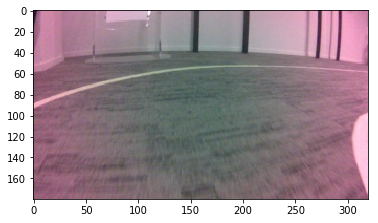

In [298]:
import matplotlib.pyplot as plt

image_path = df['filename'].values[12100]
image = load_and_preprocess_image(image_path)
plt.imshow(image)
plt.grid(False)

In [299]:
import numpy as np
import cv2 as cv

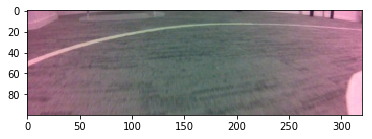

In [300]:
img_color = image.numpy()

cropped = img_color[40:140,:]
plt.imshow(cropped)

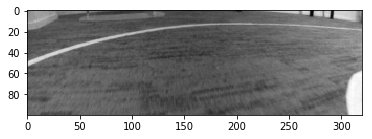

In [301]:
img_gray = cv.cvtColor(cropped,cv.COLOR_RGB2GRAY)
plt.imshow(img_gray, 'gray')

In [302]:
#masked = img_gray.copy()
#masked[0:40,:] = np.zeros((40,320))
#mask[140:180,:] = np.zeros((40,320))
#plt.imshow(masked, 'gray')

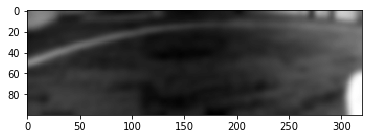

In [303]:
img_blur = cv.GaussianBlur(img_gray, (17, 17), 0)
plt.imshow(img_blur, 'gray')

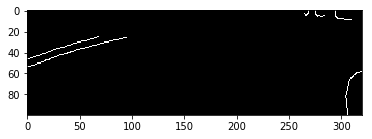

In [304]:
img_edge = cv.Canny(img_blur, threshold1=50, threshold2=80)
plt.imshow(img_edge, 'gray')

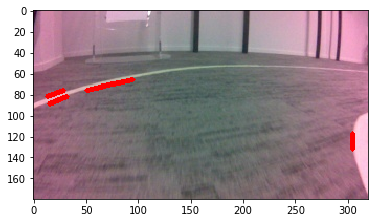

In [305]:
lines = cv.HoughLinesP(img_edge, 2, np.pi / 180, 1, np.array([]), minLineLength=15, maxLineGap=5)
lines_img = img_color.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv.line(lines_img, (x1, y1+40), (x2, y2+40), (255, 0, 0), 3)
plt.imshow(lines_img)

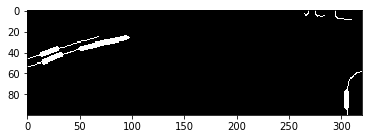

In [306]:
lines = cv.HoughLinesP(img_edge, 2, np.pi / 180, 1, np.array([]), minLineLength=15, maxLineGap=5)
lines_imgb = img_edge.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv.line(lines_imgb, (x1, y1), (x2, y2),(255), 3)
plt.imshow(lines_imgb, 'gray')

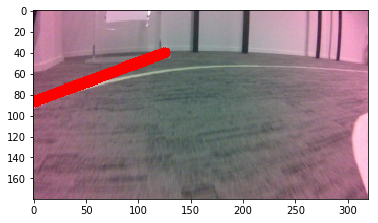

In [308]:
def slope(l):
    return (float(l[0][3]) - float(l[0][1])) / (float(l[0][2]) - float(l[0][0]) + np.finfo(float).eps)

def bias(l, s):
    return l[1] - s * l[0]

lines_with_slopes = [(l[0],slope(l)) for l in lines]
#lines_with_slopes = [(l, s) for l, s in lines_with_slopes if 0.5 <= np.abs(s) <= 2]
img_shape = img_color.shape

pos_lines = [(l, s) for l, s in lines_with_slopes if s > 0]
neg_lines = [(l, s) for l, s in lines_with_slopes if s < 0]

line_img =  img_color.copy()#np.zeros(shape=img_shape)
line_imgb = img_edge.copy()
if len(neg_lines) > 0:
    neg_bias, neg_slope = np.median([[bias(l, s), s] for l, s in neg_lines], axis=0)
    left_line = [0, np.int32(neg_bias), -np.int32(np.round(neg_bias / neg_slope)), 0]
    cv.line(line_img, (left_line[0], left_line[1]+40), (left_line[2], left_line[3]+40), [255, 0, 0], 10)
    cv.line(line_imgb, (left_line[0], left_line[1]), (left_line[2], left_line[3]), (255), 10)

if len(pos_lines) > 0:
    pos_bias, pos_slope = np.median([[bias(l, s), s] for l, s in pos_lines], axis=0)
    right_line = [0, np.int32(pos_bias), np.int32(np.round((img_shape[0] - pos_bias) / pos_slope)), img_shape[0]]
    cv.line(line_img, (right_line[0], right_line[1]+40), (right_line[2], right_line[3]+40), [255, 0, 0], 10)
    cv.line(line_imgb, (right_line[0], right_line[1]), (right_line[2], right_line[3]), (255), 10)

plt.imshow(line_img)

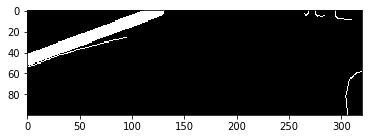

In [309]:
plt.imshow(line_imgb, 'gray')